In [1]:
import numpy as np
import numpy.linalg as lng
import matplotlib.pyplot as plt
import cheb_spectral as chebs

### Proposed function

$$ \frac{d² }{dx²} u(x) - 4\frac{d }{dx} u(x) + 4 u(x) = exp(x) - \frac{4e}{1+e²}$$

In [2]:
def gen_b_coefs(coefs,deriv_order=1):
    
    N = len(coefs)
    
    bs = np.zeros([N])
    
    
    
    for n in range(N):
        bn = 0
        mult = (3-deriv_order)/(1 + int(n==0)) # mutiplicative factor
        
        for p in range(n+deriv_order,N):
            
            # first order derivate
            if(deriv_order==1):
                # only where p+n is odd
                if ( (p+n)%2 == 0): 
                    continue
                else:
                    bn += p*coefs[p]
                    
            # second order derivate
            elif (deriv_order==2):
                # only where p+n is even
                if((p+n)%2 != 0):
                    continue
                else:
                    bn += p*(p**2 - n**2)*coefs[p]
        
        bn = bn*mult
        bs[n] = bn
        
    return bs
         
        

def compute_L_matrix(N,deriv_order=1):
    N = N+1
    L = np.zeros([N,N])
    I = np.identity(N)
    
    for i in range(N):
        L[:,i] = gen_b_coefs(I[i,:],deriv_order)
    return L

In [3]:
# S function
def s_func(x):
    return np.exp(x) - (4*np.e/(1+np.e**2))

def u_func_analytical(x):
    return np.exp(x) - (np.sinh(1)/np.sinh(2))*np.exp(2*x) - np.e/(1+np.e**2)

In [4]:
N = 6 # max order
x_space = np.linspace(-1,1,1000) 

# generate chebyshev polynomials and coefficients for S(x)
chebyshev_coefs = chebs.generate_chebyshev(N)
pols_list = chebs.func_chebyshev(chebyshev_coefs)
fvals_s = chebs.get_f_coefs(s_func,pols_list)

# constructing the differential operator
H_oper = compute_L_matrix(N,2)-4*compute_L_matrix(N,1)+4*np.identity(N+1)
H_oper

array([[  4.,  -4.,   4., -12.,  32., -20., 108.],
       [  0.,   4., -16.,  24., -32., 120., -48.],
       [  0.,   0.,   4., -24.,  48., -40., 192.],
       [  0.,   0.,   0.,   4., -32.,  80., -48.],
       [  0.,   0.,   0.,   0.,   4., -40., 120.],
       [  0.,   0.,   0.,   0.,   0.,   4., -48.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   4.]])

## Tau Method

### Implementing boundary conditions

In [5]:
H_oper[-1] = np.ones([len(H_oper[-1])]) # u(x=1) 
H_oper[-2] = np.array([(-1)**i for  i in range(len(H_oper[-2]))]) # u(x=-1)


fvals_s[-1] = 0   # u(x=1) = 0
fvals_s[-2] = 0   # u(x=-1) = 0

H_oper

array([[  4.,  -4.,   4., -12.,  32., -20., 108.],
       [  0.,   4., -16.,  24., -32., 120., -48.],
       [  0.,   0.,   4., -24.,  48., -40., 192.],
       [  0.,   0.,   0.,   4., -32.,  80., -48.],
       [  0.,   0.,   0.,   0.,   4., -40., 120.],
       [  1.,  -1.,   1.,  -1.,   1.,  -1.,   1.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.]])

### Solving the linear system

In [6]:
solution_coefs= lng.solve(H_oper,fvals_s)
solution_coefs

array([ 0.20383916,  0.09981713, -0.17557441, -0.09351038, -0.02711185,
       -0.00630675, -0.0011529 ])

In [7]:
sol = chebs.get_interpolant(solution_coefs,pols_list)

### Comparing to analytical answer

In [8]:
y_sol = sol(x_space)
y_an = u_func_analytical(x_space)

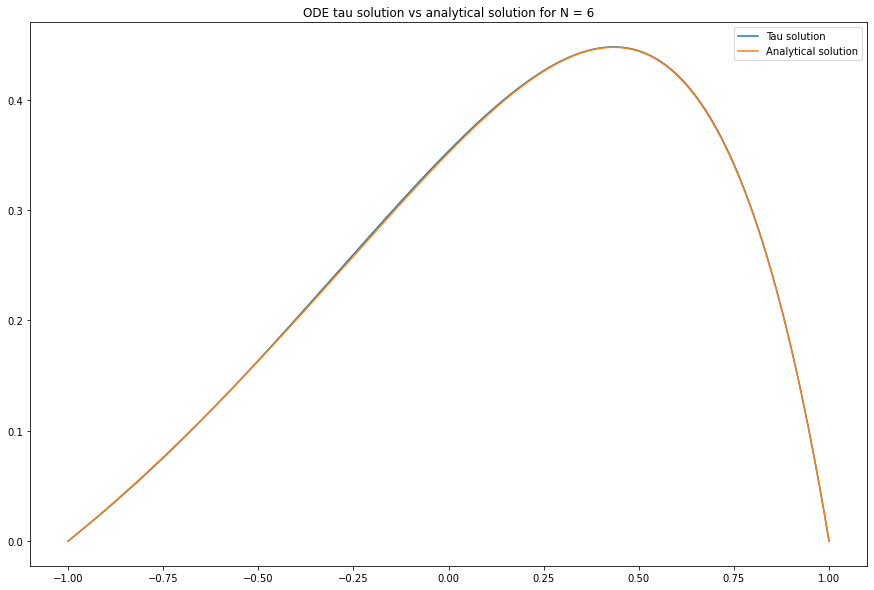

In [9]:
plt.figure(figsize=(15,10))
plt.plot(x_space,y_sol,label="Tau solution")
plt.plot(x_space,y_an,label="Analytical solution")
plt.title("ODE tau solution vs analytical solution for N = %.d"%(N))
plt.legend()

### Showing spectral convergence

In [12]:
N_max = 20
errorsMax = []
errorsMSE = []
for N in range(3,N_max):
    
    chebyshev_coefs = chebs.generate_chebyshev(N)
    pols_list = chebs.func_chebyshev(chebyshev_coefs)
    fvals_s = chebs.get_f_coefs(s_func,pols_list)
    
        
    H_oper = compute_L_matrix(N,2) - 4*compute_L_matrix(N,1) + 4*np.identity(N+1)
    
    H_oper[-1] = np.ones([len(H_oper[-1])]) # u(x=1) 
    H_oper[-2] = np.array([(-1)**i for  i in range(len(H_oper[-2]))]) # u(x=-1)

    fvals_s[-1] = 0   # u(x=1) = 0
    fvals_s[-2] = 0   # u(x=-1) = 0

    
    
    solution_coefs= lng.solve(H_oper,fvals_s)
    sol = chebs.get_interpolant(solution_coefs,pols_list)
    y_sol = sol(x_space)
    

    errorsMax.append( chebs.error_max(y_sol,y_an) )
    errorsMSE.append( chebs.error_MSE(y_sol,y_an) )

    

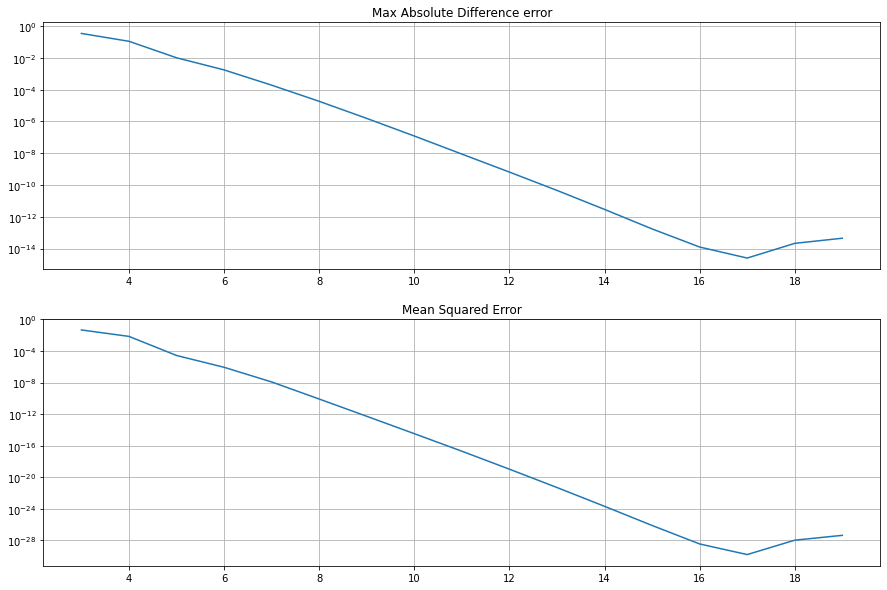

In [13]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.title("Max Absolute Difference error")
plt.plot(np.arange(3,N_max),errorsMax)
plt.grid()
plt.yscale("log")

plt.subplot(2,1,2)
plt.title("Mean Squared Error")
plt.plot(np.arange(3,N_max),errorsMSE)
plt.yscale("log")
plt.grid()

## Collocation Method

In [80]:

def build_A_matrix(N,pols,colloc,L):
    
    
    A = np.zeros([N,N])
    
    for i in range(N):
        for j in range(N):
            A[i,j] = np.sum( [L[k,j]*pols[k](colloc[i]) for k in range(N)] )
    return A

In [92]:
N = 8
chebyshev_coefs = chebs.generate_chebyshev(N)
pols_list = chebs.func_chebyshev(chebyshev_coefs)
fvals_s = chebs.get_f_coefs(s_func,pols_list)
colloc = [chebs.get_weight_colloc(i,N+1)[1] for i in range(N+1)]


H_oper = compute_L_matrix(N,2) - 4*compute_L_matrix(N,1) + 4*np.identity(N+1)
#print(len(colloc),len(fvals_s),np.shape(H_oper))
#print(H_oper.shape,np.shape(pols_list),np.shape(colloc))
H_oper[-1] = np.ones([len(H_oper[-1])]) # u(x=1) 
H_oper[0] = np.array([(-1)**i for  i in range(len(H_oper[0]))]) # u(x=-1)

fvals_s[-1] = 0   # u(x=1) = 0
fvals_s[0] = 0   # u(x=-1) = 0

A_matrix = build_A_matrix(N+1,pols_list,colloc,H_oper)
#print(np.shape(A_matrix),np.shape(fvals_s))
solution_coefs= lng.solve(A_matrix,fvals_s)
print(solution_coefs)
sol = chebs.get_interpolant(solution_coefs,pols_list)
y_sol = sol(x_space)

[ 1.22782303e+01  7.98894060e+00 -9.20180962e+00 -7.32251435e+00
 -2.87350390e+00 -7.84290084e-01 -1.63080265e-01 -2.90363145e-02
 -5.20965134e-03]


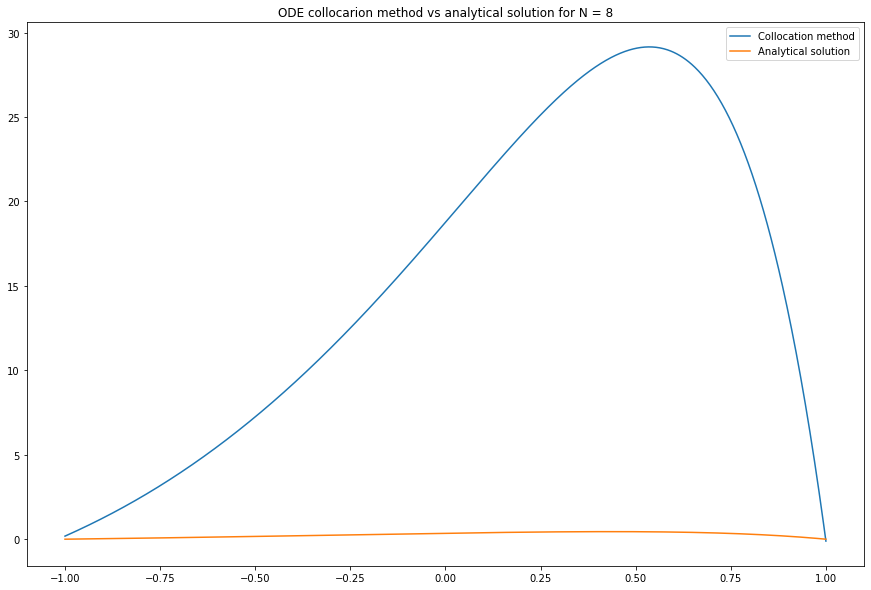

In [93]:
plt.figure(figsize=(15,10))
plt.plot(x_space,y_sol,label="Collocation method")
plt.plot(x_space,y_an,label="Analytical solution")
plt.title("ODE collocarion method vs analytical solution for N = %.d"%(N))
plt.legend()

### spectral convergence

In [106]:
pols_list[4](colloc[2])

-1.0000000000000004

In [94]:
A_matrix

array([[ 2.00000000e+00, -4.00000000e+00,  2.20000000e+01,
        -5.20000000e+01,  1.18000000e+02, -2.84000000e+02,
         4.62000000e+02, -9.56000000e+02,  1.34600000e+03],
       [ 0.00000000e+00, -5.69551813e+00,  1.76104996e+01,
        -4.26744053e+01,  7.57511404e+01, -1.70233756e+02,
         1.77282292e+02, -3.51588549e+02,  1.81019336e+02],
       [ 2.00000000e+00, -2.82842712e+00,  1.33137085e+01,
        -1.41421356e+01, -2.00000000e+00,  1.45441559e+01,
        -1.51941125e+02,  1.32367532e+02, -3.82000000e+02],
       [-2.22044605e-16, -3.53073373e+00,  3.29450779e+00,
         9.48167850e+00, -5.12594007e+01,  5.05771038e+01,
        -1.14567270e+02, -2.55763919e+01, -1.81019336e+02],
       [ 2.00000000e+00, -2.22044605e-16, -2.00000000e+00,
         2.40000000e+01, -4.20000000e+01,  7.10542736e-15,
        -7.40000000e+01,  5.60000000e+01, -3.18000000e+02],
       [-4.44089210e-16, -4.69266271e-01, -8.95136204e+00,
         2.04594470e+01, -1.66228503e+01,  1.991438

In [ ]:
##